CNN has been used intensively in image processing tasks. However, what about in text? is it feasible to use it in text? and what kind of output will it be translated when we're using CNN in text?

Quoted from [Yoav Goldberg's book](https://www.amazon.com/Language-Processing-Synthesis-Lectures-Technologies/dp/1627052984)
> The 1D convolution approach described so far can be thought of as ngram detector. A convolution layer with a windows of size k is learning to identify indicative k-grams in the input.



So when we use 1D CNN on text, we approximate a function to determine which texts/ which n-grams are important to a task.

**In this short notebook, I will make experiement what kind of "importance" will 1D CNN detect when given a text classification task.**

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

In [3]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.nn import functional as F
from torch.optim import Adam
import numpy as np
from IPython.core.display import HTML
from copy import copy
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

Here, I'll experiment with BBC News data from [kaggle](https://www.kaggle.com/c/learn-ai-bbc). The data has been pre-downloaded into my disk.

In [4]:
df = pd.read_csv("data/BBC News Train.csv")

<IPython.core.display.Javascript object>

First thing first, I'll make 2 variables `texts` and `labels` so I could use `scikit`'s `train_test_split` function to split that training data, into 20% test set and the rest will be used to train the model.

In [5]:
texts = df.Text.values
labels = df.Category.values

<IPython.core.display.Javascript object>

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, train_size=0.8, random_state=22
)

<IPython.core.display.Javascript object>

Next I will define `Vocabulary` and `LabelVocabulary` to transform `texts` and `labels` into "encoded" version.

In [7]:
class LabelVocabulary(object):
    def __init__(self):
        self._label_encoder = LabelEncoder()

    def fit(self, labels):
        self._label_encoder.fit(labels)

    def to_index(self, label):
        return self._label_encoder.transform([label])[0]

    def to_indexes(self, labels):
        return self._label_encoder.transform(labels)

    def to_labels(self, indexes):
        return self._label_encoder.inverse_transform(indexes)

<IPython.core.display.Javascript object>

In [8]:
class Vocabulary(object):
    def __init__(self, lower=True):
        self._itow = {}  # index to word
        self._wtoi = {}  # word to index
        self._lower = lower
        self.PAD_TOKEN = "<PAD>"
        self.PAD_IDX = 10
        self.UNK_TOKEN = "<UNK>"
        self.UNK_IDX = 0
        self.len_vocab = 0
        self.max_idx = 0

    def _tow(self, word):
        if self._lower:
            return word.lower()
        return word

    def wtoi(self, word):
        w = self._tow(word)
        if w not in self._wtoi:
            return self.UNK_IDX

        return self._wtoi[w]

    def itow(self, i):
        if i not in self._itow:
            return self.UNK_TOKEN

        return self._itow[i]

    def fit(self, texts):
        i = 100
        for text in tqdm(texts):
            for word in text.split():
                w = self._tow(word)

                if w not in self._wtoi:
                    self._wtoi[w] = i
                    self._itow[i] = w
                    i += 1
                    self.len_vocab = i - 100
                    self.max_idx = i
        return self

    def to_padded_idx(self, text, max_seq_len=256):
        padded_idxs = []
        for word in text.split()[:max_seq_len]:
            w = self._tow(word)
            word_index = self.wtoi(w)
            padded_idxs.append(word_index)

        if len(padded_idxs) < max_seq_len:
            diff = max_seq_len - len(padded_idxs)
            for k in range(diff):
                padded_idxs.append(self.PAD_IDX)
        return padded_idxs

    def to_padded_idxs(self, texts, max_seq_len=256):
        res = []
        for text in tqdm(texts):
            res.append(self.to_padded_idx(text))
        return res

    def __len__(self):
        return self.len_vocab

<IPython.core.display.Javascript object>

In [9]:
vocabulary = Vocabulary()
vocabulary.fit(X_train)

  0%|          | 0/1192 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [10]:
label_vocabulary = LabelVocabulary()
label_vocabulary.fit(y_train)

<IPython.core.display.Javascript object>

Then I will need to create `Dataset` abstraction that will be used by `pytorch` to load data, from
```
texts = [
    'some text here',
    ...
],
labels = [
    'entertainment',
    ...
]
```

to 
```
{
    'input_ids': [
        [20, 52, 78 ...], # assuming 'some' -> 20, 'text' -> 52, 'here' -> 78 by Vocabulary
        ...
    ],
    'label': [
        0, # assuming 0 -> 'entertainment' by LabelVocabulary
        ...
    ]
}
```

In [11]:
class SimpleDataset(Dataset):
    def __init__(self, vocab, label_vocab, texts, labels=None, max_seq_len=256):
        self._vocab = vocab
        self._label_vocab = label_vocab
        self._texts = texts
        self._labels = labels
        self._max_seq_len = max_seq_len

    def __len__(self):
        return len(self._texts)

    def __getitem__(self, idx):
        result = {}
        result["input_ids"] = torch.tensor(
            self._vocab.to_padded_idx(self._texts[idx], max_seq_len=self._max_seq_len),
            dtype=torch.long,
        )

        if self._labels is not None:
            result["label"] = torch.tensor(
                self._label_vocab.to_index(self._labels[idx]), dtype=torch.long
            )
        return result

<IPython.core.display.Javascript object>

In [12]:
train_dataset = SimpleDataset(vocabulary, label_vocabulary, X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=8)

<IPython.core.display.Javascript object>

In [28]:
test_dataset = SimpleDataset(vocabulary, label_vocabulary, X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=8)

<IPython.core.display.Javascript object>

I will then train a simple model, which has this architecture

[![svg](https://mermaid.ink/img/eyJjb2RlIjoiZ3JhcGggTFJcbiAgIEkoKGlucHV0KSkgLS0-IEUoKGVtYmVkZGluZykpXG4gICBFIC0tPiBDKChDTk4gMUQpKVxuICAgQyAtLT4gUFtNYXggUG9vbCAxRF1cbiAgIFAgLS0-IEwoKExpbmVhcikpXG4gICAiLCJtZXJtYWlkIjp7InRoZW1lIjoiZGVmYXVsdCJ9LCJ1cGRhdGVFZGl0b3IiOmZhbHNlLCJhdXRvU3luYyI6dHJ1ZSwidXBkYXRlRGlhZ3JhbSI6ZmFsc2V9)](https://mermaid-js.github.io/mermaid-live-editor/edit##eyJjb2RlIjoiZ3JhcGggTFJcbiAgIEkoKGlucHV0KSkgLS0-IEUoKGVtYmVkZGluZykpXG4gICBFIC0tPiBDKChDTk4gMUQpKVxuICAgQyAtLT4gUFtNYXggUG9vbCAxRF1cbiAgIFAgLS0-IEwoKExpbmVhKSlcbiAgICIsIm1lcm1haWQiOiJ7XG4gIFwidGhlbWVcIjogXCJkZWZhdWx0XCJcbn0iLCJ1cGRhdGVFZGl0b3IiOmZhbHNlLCJhdXRvU3luYyI6dHJ1ZSwidXBkYXRlRGlhZ3JhbSI6ZmFsc2V9)

The idea is to train a simple classifier and connect the interim output (until Max Pool 1D) back to the ngrams of the sentences.


Here I will define ngrams to be 3, hence the $\text{kernel size} = \text{ngrams} = 3$

In [16]:
class ModelConfig(object):
    def __init__(self, vocabulary, label_vocabulary, seq_len=256):
        self.vocab_size = vocabulary.max_idx + 1
        self.embed_dim = 100
        self.cnn_output_dim = 50
        self.n_grams = 3  # kernel_size
        self.cls_in_dim = (seq_len - (self.n_grams - 1)) // self.n_grams
        self.n_class = len(label_vocabulary._label_encoder.classes_)
        self.seq_len = seq_len


class SimpleModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed = nn.Embedding(config.vocab_size, config.embed_dim)
        self.cnn = nn.Conv1d(config.embed_dim, config.cnn_output_dim, config.n_grams)
        self.max_pool = nn.MaxPool1d(config.n_grams)

        self.classifier = nn.Linear(
            config.cls_in_dim * config.cnn_output_dim, config.n_class
        )

    def forward(self, x):
        batch_size, seq_len = x.shape
        # (batch_size, seq_len, embed_dim)
        z = self.embed(x)
        # (batch_size, embed_dim, seq_len)
        z = z.permute(0, 2, 1)
        # (batch_size, cnn_output_dim - kernel_size + 1, seq_len)
        z = self.cnn(z)
        # max_pool: (batch_size, (cnn_output_dim - kernel_size + 1) / kernel_size, seq_len)
        # view: (batch_size, seq_len * (cnn_output_dim - kernel_size + 1) / kernel_size)
        z = self.max_pool(z).view(batch_size, -1)
        # (batch_size, n_class)
        logits = self.classifier(z)
        return logits

<IPython.core.display.Javascript object>

In [17]:
def accuracy(y_true, y_pred):
    batch_size = y_true.shape[0]
    return (y_true == y_pred).sum().item() / batch_size

<IPython.core.display.Javascript object>

In [18]:
def to_ngram_probs(indices, window_size):
    batch_size, out_channel_size, pool_size = indices.shape
    batches_w = []
    batches = []
    for b in range(batch_size):
        w = []
        x = []
        for p in range(pool_size):
            indicies_slice = indices[b][:, p]
            counts = torch.bincount(indicies_slice, minlength=window_size)
            probs = counts / counts.sum()
            w.append(counts)
            x.append(probs)
        batches_w.append(torch.stack(w))
        batches.append(torch.stack(x))
    return torch.stack(batches_w), torch.stack(batches)

<IPython.core.display.Javascript object>

In [19]:
SPAN_START = '<span style="background-color: #FFFF00">'
SPAN_END = "</span>"


def visualize_sentence(sentence, highlight_indexes):
    result = []
    temp_indexes = copy(highlight_indexes)
    for i in range(len(sentence)):
        start = -1
        end = -1
        if len(temp_indexes) > 0:
            start, end = temp_indexes[0]

        if i == start:
            result.append(SPAN_START)

        result.append(sentence[i])

        if i == end:
            result.append(SPAN_END)
            temp_indexes.pop(0)

    display(HTML(" ".join(result)))

<IPython.core.display.Javascript object>

In [86]:
def to_highlight_indexes(important_ngram_idx, ngram_window=2):
    highlight_indexes_batch = []
    last_batch_idx = -1

    for batch_idx, ngram_idx in important_ngram_idx:
        if batch_idx > last_batch_idx:
            highlight_indexes_batch.append([])
            last_batch_idx = batch_idx

        start_ngram_idx = ngram_idx
        end_ngram_idx = start_ngram_idx + ngram_window
        highlight_indexes_batch[-1].append((start_ngram_idx, end_ngram_idx))

    return highlight_indexes_batch

<IPython.core.display.Javascript object>

In [22]:
def to_words(vocab, batched_ids):
    sentences = []
    for batch in batched_ids:
        sentences.append([vocab.itow(token_id) for token_id in batch])

    return sentences

<IPython.core.display.Javascript object>

In [23]:
# here I'll use GPU, but CPU will work just fine
device = "cuda"

<IPython.core.display.Javascript object>

In [24]:
model_config = ModelConfig(vocabulary, label_vocabulary)
model = SimpleModel(model_config).to(device)
optimizer = Adam(lr=1e-3, params=model.parameters())

<IPython.core.display.Javascript object>

In [25]:
n_epochs = 10
pbar = tqdm(range(n_epochs))
for epoch in pbar:
    epoch_losses = []
    epoch_accuracies = []

    for batch in train_dataloader:
        optimizer.zero_grad()
        logits = model(batch["input_ids"].to(device))
        _, y_pred = logits.max(dim=1)
        labels = batch["label"].to(device)
        loss = F.cross_entropy(logits, labels)
        batch_loss = loss.item()

        epoch_losses.append(batch_loss)
        epoch_accuracies.append(accuracy(labels, y_pred))

        loss.backward()
        optimizer.step()

    mean_epoch_losses = np.mean(epoch_losses)
    mean_epoch_acc = np.mean(epoch_accuracies)
    pbar.set_description(f"[E]loss: {mean_epoch_losses:.3f}, acc: {mean_epoch_acc:.2f}")

  0%|          | 0/10 [00:00<?, ?it/s]

/home/arie/miniconda3/envs/da38/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


<IPython.core.display.Javascript object>

In [30]:
with torch.no_grad():
    test_accuracies = []
    test_losses = []
    pbar = tqdm(test_dataloader)

    for batch in pbar:
        logits = model(batch["input_ids"].to(device))
        _, y_pred = logits.max(dim=1)
        labels = batch["label"].to(device)
        loss = F.cross_entropy(logits, labels)
        batch_loss = loss.item()

        test_losses.append(batch_loss)
        test_accuracies.append(accuracy(labels, y_pred))

        mean_test_loss = np.mean(test_losses)
        mean_test_accuracy = np.mean(test_accuracies)
        pbar.set_description(
            f"[T]loss: {mean_test_loss:.3f}, acc: {mean_test_accuracy:.2f}"
        )

  0%|          | 0/38 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

Let's peek at the test accuracies per batch

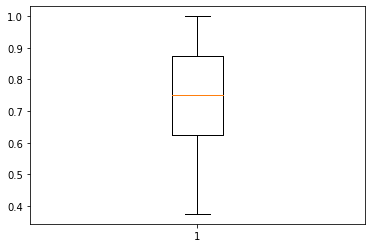

<IPython.core.display.Javascript object>

In [114]:
plt.boxplot(test_accuracies)
plt.show()

it seems that my simple model has done pretty good job in this text classification dataset, it has median of ~75% accuracy for test dataset.

Now I will take a sample from test dataloader and see what will the CNN + pooling detect in our sentences ngrams

In [31]:
test_sample = next(iter(test_dataloader))

<IPython.core.display.Javascript object>

In [32]:
with torch.no_grad():
    embedded = model.embed(test_sample["input_ids"].to(device))
    embedded = embedded.permute(0, 2, 1)
    result = model.cnn(embedded)

<IPython.core.display.Javascript object>

here I used `max_pool1d_with_indices` so that I can also extract the `indices` of max on each sliding window. It pretty much doing the argmax of each sliding window.

In [33]:
# max_pooled (batch_size, seq_len, n_slide/kernel_size)
# indices (batch_size, seq_len, n_slide/kernel_size)
max_pooled, indices = F.max_pool1d_with_indices(result, 3)

<IPython.core.display.Javascript object>

then I will construct `n_gram_counts` with shape `[batch_size, pooled_size, n_sliding_windows]` that looks like this
```
[
    # batch 1
    [
      [10, 5, 7, 0,  0, 0],
      [ 0, 9, 8, 4,  0, 0],
      [ 0, 0, 3, 4, 10, 0],
      ...
    ],
    ...
]
```

for 

$\text{sequence length} = 256$

$\text{kernel size} = 3$

then (also assuming other parameters for CNN is left to default)

$$\text{n sliding windows} = \text{sequence length} - \text{kernel size} + 1 = 254$$

$$\text{pooled size} = floor(\frac{\text{n sliding windows}}{\text{kernel size}}) = 84 $$

In [34]:
# n_gram_counts (batch_size, pooled_size, cnn_output_size)
n_gram_counts, _ = to_ngram_probs(indices, 254)

<IPython.core.display.Javascript object>

Then for each sliding windows (was 254 in the previous explanation), we wanted to see which sliding windows are the most important. One way to do that is by summing the count in axis=1 and divide it with maximum of the counts, see this example for illustration
```
[
    # batch 1
    [
      [10,  5,  7, 0,  0, 0],
      [ 0,  9,  8, 4,  0, 0],
      [ 0,  0,  3, 4, 10, 0],
      ...
      |
      |
      v
      
      [10, 14, 18, 8,  0, 0],
      
      |
      |
      v
      [0.55, 0.78, 1.0, 0.44,  0, 0], # divide all by max of those counts, which is 18
    ],
    ...
]
```

In [46]:
sum_per_sliding_windows = n_gram_counts.sum(axis=1)
max_per_batch, _ = sum_per_sliding_windows.max(axis=1)

<IPython.core.display.Javascript object>

In [51]:
prob_per_sliding_windows = sum_per_sliding_windows / max_per_batch.view(-1, 1)

<IPython.core.display.Javascript object>

Now I'm gonna set arbitrary threshold, **0.8**, which seems make sense to me, so that we can filter which sliding windows are seems to be very important from the model point of view and neglect the sliding windows which less than that threshold.

```
[
  [0.55, 0.78, 1.0, 0.44,  0, 0]
  
  |
  |
  v
  [0, 0, 1.0, 0,  0, 0] # zero out all that less than 0.8
  
]
```

In [59]:
threshold = 0.8

important_sliding_windows = torch.where(
    (prob_per_sliding_windows > threshold) & (prob_per_sliding_windows <= 1.0),
    prob_per_sliding_windows,
    torch.zeros_like(prob_per_sliding_windows),
)

<IPython.core.display.Javascript object>

In [60]:
important_ngram_idx = (
    (important_sliding_windows >= threshold).nonzero(as_tuple=True)[0].cpu().numpy()
)

<IPython.core.display.Javascript object>

In [75]:
important_ngram_idx = (important_sliding_windows >= threshold).nonzero().cpu().numpy()

<IPython.core.display.Javascript object>

In [87]:
highlight_indexes = to_highlight_indexes(important_ngram_idx)

<IPython.core.display.Javascript object>

In [97]:
sentences = to_words(vocabulary, test_sample["input_ids"].cpu().numpy())

<IPython.core.display.Javascript object>

In [102]:
test_labels = label_vocabulary.to_labels(test_sample["label"].cpu().numpy())

<IPython.core.display.Javascript object>

Now I can visualize which ngrams that my model deemed important.

In [104]:
batch_idx = 0

print(f"label : {test_labels[batch_idx]}")
visualize_sentence(sentences[batch_idx], highlight_indexes[batch_idx])

label : entertainment


<IPython.core.display.Javascript object>

In [105]:
batch_idx = 1
print(f"label : {test_labels[batch_idx]}")
visualize_sentence(sentences[batch_idx], highlight_indexes[batch_idx])

label : business


<IPython.core.display.Javascript object>

In [115]:
batch_idx = 2
print(f"label : {test_labels[batch_idx]}")
visualize_sentence(sentences[batch_idx], highlight_indexes[batch_idx])

label : sport


<IPython.core.display.Javascript object>